In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ceyx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load training and test data


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df.head(10)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\r\n\r\nCongratulations from me as well, use ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are no missing numeric values. As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. From this I guess that there would be many comments which are not labelled in any of the six categories. Let's take a look.



In [5]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [6]:
# check for any 'null' comment in train set
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)


0

In [7]:
# check for any null comment in test set
no_comment_test = test_df[test_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [9]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))


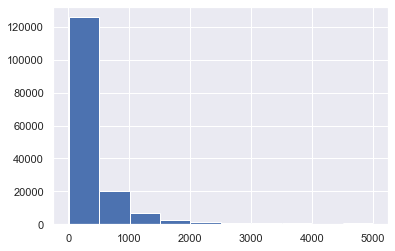

In [10]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

In [11]:
data = train_df[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

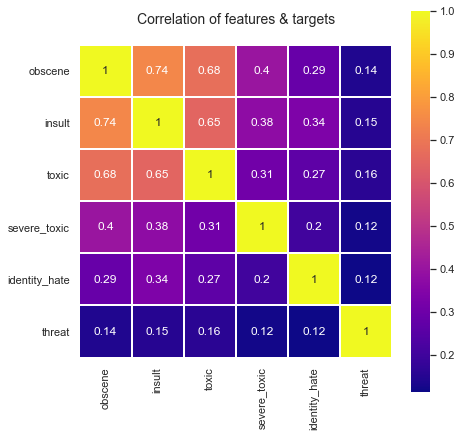

In [12]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

What about the character length & distribution of the comment text in the test data?


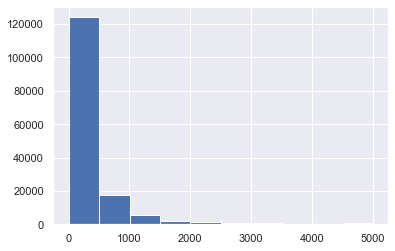

In [13]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

Now, the shape of character length distribution looks similar between the training data and the test data. For the training data, I guess the test data were clipped to 5,000 characters to facilitate the folks who did the labelling of the comment categories.

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
   ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in(stop_words)])    ### Stopwords removal
    return text

In [15]:
# clean the comment_text in train_df 
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))
# clean the comment_text in test_df 
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

In [16]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,265
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,112
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,626
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0,67
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,44
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,115
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,472
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,70


In [17]:
train_df = train_df.drop('char_length',axis=1)

In [18]:
X_train = train_df.comment_text
y_train = train_df[cols_target]
X_test = test_df.comment_text
test_df.head()
print(X_test.shape, X_train.shape)

(153164,) (159571,)


Veoctorize data

In [19]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

vect

TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [20]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_tf = vect.fit_transform(X_train)

# examine the document-term matrix created from X_train
X_train_tf

<159571x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3346834 stored elements in Compressed Sparse Row format>

In [21]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_tf = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_tf

<153164x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2813940 stored elements in Compressed Sparse Row format>

Classifier Chains. In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.

In [22]:
import skmultilearn as sm
from sklearn.svm import SVC

In [23]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 

In [28]:
classifier = ClassifierChain(classifier = SVC(),
    require_dense = [False, True])
    



In [29]:
# train
classifier.fit(X_train_tf, y_train.to_numpy())



In [ ]:
# predict on train data because we do not have labels on test data
y_predicted = classifier.predict(X_train_tf)


In [ ]:
# accuracy

print("Training accuracy is  = ", metrics.accuracy_score( y_train.to_numpy(), y_predicted))


in the above method we predicted the labels as a whole and so we did not find the metrics for each label, another approach to predict them each one with Logistic reggression if the one below 

In [180]:
# import and instantiate the Logistic Regression model

logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv('./data/sample_submission.csv')

from scipy.sparse import csr_matrix, hstack

def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

for label in cols_target:
    print('... Processing {}'.format(label))
    y_train = train_df[label]
    # train the model using X_train_tf and y_train
    logreg.fit(X_train_tf,y_train)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_train_tf) # predicted on train set again because we do not have test label data
    print('Training Accuracy is {}'.format(accuracy_score(y_train,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(X_test_tf)
    test_y_prob = logreg.predict_proba(X_test_tf)[:,1]
    submission_binary[label] = test_y_prob
    # chain current label to X_train_tf
    X_dtm = add_feature(X_train_tf, y_train)
    print('Shape of X_train is now {}'.format(X_train_tf.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(X_test_tf, test_y)
    print('Shape of test_X_dtm is now {}'.format(X_test_tf.shape))

... Processing obscene
Training Accuracy is 0.983223768729907
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult
Training Accuracy is 0.9818137380852411
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic
Training Accuracy is 0.9675818287784121
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic
Training Accuracy is 0.9931065168482995
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate
Training Accuracy is 0.9955881707829117
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat
Training Accuracy is 0.9985649021438733
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)
